<a href="https://colab.research.google.com/github/bwallac1/App-Analysis-/blob/main/Competitive_App_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/data-mining/sentiment-analysis/sentiment-analysis.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/data-mining/sentiment-analysis/sentiment-analysis.ipynb)

Purpose:

Explore Sentiment analysis, utilizing traditional approaches of ML

It is often known as opinion mining, is a technique used in natural language processing (NLP) to determine the emotional undertone of a text. This is a common method used by organizations to identify and group opinions about their product, service, and ideas. In this notebook, I apply this technique to the 5 CS Education apps and understand customer perception and potential areas that need improvement. To do this, I:

1.	Generate Sentiment labels and scores based on customer reviews.
2.	Store them in a Pinecone index as metadata (alongside respective text vectors).
3.	Query Pinecone index on selected areas and understand customer opinions.





# Install Dependencies

In [2]:
!pip install sentence_transformers pinecone-client==3.1.0 datasets seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
pip install app-store-scraper-mod

# Load and Prepare Dataset

We use a dataset containing 150 user reviews from 5 CS Ed apps scraped from the Apple app store.

In [18]:
#Get User reviews from App Store
from app_store_scraper import AppStore
import pandas as pd


kodable= AppStore(country="us", app_name="kodable-basics")
kodable.review(how_many= 500)

mimo= AppStore(country="us", app_name="mimo-learn-coding-programming")
mimo.review(how_many= 500)

cademy= AppStore(country="us", app_name="codecademy-go")
cademy.review(how_many= 500)

codea_app= AppStore(country="us", app_name = "codea", app_id="439571171")
codea_app.review(how_many= 500)

encode_app= AppStore(country="us", app_name="encode-learn-to-code")
encode_app.review(how_many= 500)


# load the dataset and convert to pandas dataframe and create text files for reviews for each app
df = pd.DataFrame(kodable.reviews)

print(df)

text = " ".join(review for review in df.review)
with open('kodable_reviews_.txt', 'a') as fp:
    fp.write(text)

df = pd.DataFrame(mimo.reviews)

text = " ".join(review for review in df.review)
with open('mimo_reviews_.txt', 'a') as fp:
    fp.write(text)

df = pd.DataFrame(cademy.reviews)
text = " ".join(review for review in df.review)
with open('cademy_reviews_.txt', 'a') as fp:
    fp.write(text)

df = pd.DataFrame(codea_app.reviews)
text = " ".join(review for review in df.review)
with open('codea_reviews_.txt', 'a') as fp:
    fp.write(text)

df = pd.DataFrame(encode_app.reviews)
print(df)

text = " ".join(review for review in df.review)
with open('encode_reviews_.txt', 'a') as fp:
    fp.write(text)

                   date                                             review  \
0   2018-10-09 21:19:26  I really enjoy this game so far! It’s teaching...   
1   2019-04-21 14:46:57  I have a question why is it called bug world w...   
2   2022-01-31 13:37:29  They don’t tell you it’s a 7day subscription b...   
3   2024-03-29 21:11:44  We somehow canceled a free trial that accident...   
4   2021-12-11 20:21:57  Can you guys make some new planets? I love the...   
..                  ...                                                ...   
440 2014-10-08 22:42:56  This is genius! An engaging and fun way for ki...   
441 2013-12-11 16:22:13  My students loved the Hour of Code so much, th...   
442 2013-06-26 19:19:05  As a teacher, I know that elementary aged stud...   
443 2013-06-26 15:27:09  Just returned home from the CMS training and r...   
444 2013-01-10 04:51:54  I love the idea of this app.  I have three boy...   

     rating  isEdited            userName  \
0         5     Fa

In [12]:
# keep only the first 800 characters from the reviews
df["review"] = df["review"].str[:800]
# glimpse the dataset
df.head()

,date,review,rating,isEdited,title,userName,developerResponse
0,2018-10-09 21:19:26,I really enjoy this game so far! It’s teaching...,5,False,Kodable game,Jessiesays,NaN
1,2019-04-21 14:46:57,I have a question why is it called bug world w...,3,False,Busted bug world,2CAKids,NaN
2,2022-01-31 13:37:29,They don’t tell you it’s a 7day subscription b...,1,False,Great concept except,OGSkullkid,NaN
3,2024-03-29 21:11:44,We somehow canceled a free trial that accident...,1,False,Watch your money,highly ck,NaN
4,2021-12-11 20:21:57,Can you guys make some new planets? I love the...,4,False,More new stuff and planets,hihytfkljhygtdftgy,NaN


# Initialize Sentiment Analysis Model

We will use a RoBERTa model fine-tuned for sentiment analysis to analyze the app reviews. The model can be loaded from the HuggingFace a open source ML model hub as follows:

In [20]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

The sentiment analysis model returns `LABEL_0` for negative, `LABEL_1` for neutral and `LABEL_2` for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [22]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [24]:
# view review number 141
test_review = df["review"][141]
test_review

'Great app'

In [25]:
# get the sentiment label and score for review number 141
nlp(test_review)

[{'label': 'LABEL_2', 'score': 0.9504569172859192}]

Our pipeline is working as expected and accurately predicts the correct label for the review.

# This next section I attempt to index labeled reviews for querrying later. While this approach has lots of promise. I was not able to complete this with in the time of the project for all apps. So you can skip to the end to see the visualization barchart.

# Initialize Retriever

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [26]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Initialize Pinecone Index

Now we need to initialize our Pinecone index. The Pinecone index stores vector representations of our passages which we can retrieve using another vector (the query vector). We first need to initialize our connection to Pinecone. For this, we need a free [API key](https://app.pinecone.io/), we initialize the connection like so:

In [27]:
pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 6.6 MB/s eta 0:00:00


In [28]:
PINECONE_API_KEY="pcsk_5ykc1u_Lgc1MYfXPChW6nfk8as7UBgxLShqfWC2kWSYWcMmKagCdVkhHAxcGsZmocrySTA"

In [29]:
import os
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.environ.get('PINECONE_API_KEY') or 'PINECONE_API_KEY'

# configure client
pc = Pinecone(api_key="pcsk_5ykc1u_Lgc1MYfXPChW6nfk8as7UBgxLShqfWC2kWSYWcMmKagCdVkhHAxcGsZmocrySTA")

Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [30]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

Now we can create our vector index. We will name it `sentiment-mining` (feel free to choose any name you prefer). We specify the metric type as `cosine` and dimension as `384` as these are the vector space and dimensionality of the vectors generated by the retriever model.

In [31]:
index_name = "app-sentiment-mining-v2"

In [32]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=384,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 384}},
 'total_vector_count': 384}

# Generate Embeddings and Upsert

We generate embeddings for all the reviews in the dataset. Alongside the embeddings, we also include the sentiment label and score in the Pinecone index as metadata. Later we will use this data to understand customer opinions.

Let's first write a helper function to generate sentiment labels and scores for a batch of reviews.

In [33]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [34]:
# get sentiment labels for few reviews
get_sentiment(df["review"][:3].tolist())

(['neutral', 'positive', 'positive'],
 [0.40522944927215576, 0.9715114831924438, 0.889432966709137])

Need to convert the review dates to timestamps to filter query results for a given period. This is helpful to understand customer sentiment over a specific period.

In [35]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [d.timestamp() if hasattr(d, 'timestamp') else dateutil.parser.parse(str(d)).timestamp() for d in dates]
    return timestamps

In [36]:
get_timestamp([df["date"][0]])[0]

1506658545.0

Now we create the embeddings. We do this in batches of `64` to avoid overwhelming machine resources or API request limits.

In [37]:
from tqdm.auto import tqdm
import json

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):

    # find end of batch
    i_end = min(i + batch_size, len(df))

    # extract batch
    batch = df.iloc[i:i_end].copy()

    # generate embeddings for batch
    emb = retriever.encode(batch["review"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    timestamp = get_timestamp(batch["date"].tolist())
    batch.loc[:,"timestamp"] = timestamp

    # Tokenize and pad the reviews with a fixed max_length
    inputs = tokenizer(
        batch["review"].tolist(),
        padding="max_length",  # Pad to max_length
        truncation=True,       # Truncate if longer than max_length
        max_length=512,        # Set a fixed max_length (e.g., 512)
        return_tensors="pt"    # Return PyTorch tensors
    )

    # Move inputs to the appropriate device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted labels and scores
    predicted_labels = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    scores_array = torch.softmax(outputs.logits, dim=1).cpu().numpy() # Renamed to avoid conflict

    # Convert predicted labels to sentiment labels
    label = [labels[f"LABEL_{label}"] for label in predicted_labels]
    # Extracting scores based on predicted labels using scores_array
    score = [scores_array[i][predicted_labels[i]] for i in range(len(predicted_labels))]

    batch.loc[:,"label"] = label
    batch.loc[:,"score"] = score

    # Convert 'date' column to string before creating metadata
    batch['date'] = batch['date'].astype(str) # This line is added to convert the date to a string


    # get metadata
    meta = batch.to_dict(orient="records")

    # Iterate through metadata and replace NaN or None values
    for item in meta:
        for key, value in item.items():
            if pd.isnull(value) or value is None:  # Check for NaN or None
                item[key] = ""  # Or any other suitable replacement
            # Stringify nested dictionaries:
            if isinstance(value, dict):
                item[key] = json.dumps(value)

    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone


  0%|          | 0/4 [00:00<?, ?it/s]

We have successfully indexed all customer reviews and relevant metadata. We can move on to opinion mining.

# Opinion Mining

In [38]:
query = "What are the most helpful features for learning basic programming?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=500, include_metadata=True)

Let's take a look at a few reviews from the search results.

In [39]:
result["matches"][:5]

[{'id': '302',
  'metadata': {'date': '2012-12-06 17:01:06',
               'developerResponse': '',
               'isEdited': False,
               'label': 'neutral',
               'rating': 5.0,
               'review': 'I always wondered how to get teaching programming to '
                         'kids more than just a series of steps. \n'
                         '\n'
                         'They have these colored squares in the game, so that '
                         "you don't just move your little guy around with a "
                         'series of commands, you can tell him to "if you hit a '
                         'red square, turn left, otherwise, go straight". \n'
                         '\n'
                         'Seems like a good start',
               'score': 0.47725406289100647,
               'timestamp': 1354813266.0,
               'title': 'Very cute. Kids love it. Good Branching Logic',
               'userName': 'Embwbam'},
  'score': 0.5355563

In [40]:
result["matches"][-5:]

[{'id': '271',
  'metadata': {'date': '2023-01-21 01:07:36',
               'developerResponse': '',
               'isEdited': False,
               'label': 'negative',
               'rating': 1.0,
               'review': 'No delete the app',
               'score': 0.7808582782745361,
               'timestamp': 1674263256.0,
               'title': 'Boo',
               'userName': 'Bunny lover1728873219'},
  'score': -0.0370275863,
  'values': []},
 {'id': '258',
  'metadata': {'date': '2019-01-11 21:33:02',
               'developerResponse': '{"id": 6830064, "body": "Hi '
                                    'Gxskillz,\\nWhile you do need to start a '
                                    'trial with your Apple ID before using '
                                    'Kodable, you are definitely *not* charged '
                                    'until the end of the trial period, so you '
                                    'can always try Kodable without having to '
             

Reviews relevant to learning programming from the search results. Now let's see the overall perception of the users. First, I need to extract the sentiment labels from the query results and count them.

In [41]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [42]:
sentiment = count_sentiment(result)
sentiment

{'negative': 140, 'neutral': 38, 'positive': 206}

**Barchart of Sentiment Analysis **



<Axes: >

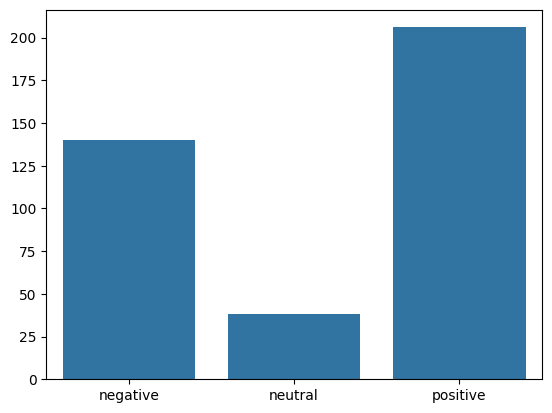

In [43]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))